### Port-Hamiltonian Optimizer
Copyright (c) 2020. Daniel Albert. Published under the GNU General Public License.

This notebook will explore the feasibility of learning a linear boundary with the Port-Hamiltonian based optimizer.
The distribution is created and seeded with the same parameters as the one by Massaroli et al., such that we may directly compare the results obtained.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split

from PHOptimizer import PortHamiltonianOptimizer as PHOpt

Create some test data

In [3]:
N = 1000

np.random.seed(1)
X1 = np.random.multivariate_normal([0.6, 0.7], [[0.025, 0.0], [0.0, 0.01]], N)
Y1 = np.hstack((np.ones((N, 1)), np.zeros((N, 1))))

np.random.seed(2)
X2 = np.random.multivariate_normal([0.1, 0.2], [[0.025, -0.00], [-0.00, 0.01]], N)
Y2 = np.hstack((np.zeros((N, 1)), np.ones((N, 1))))

X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

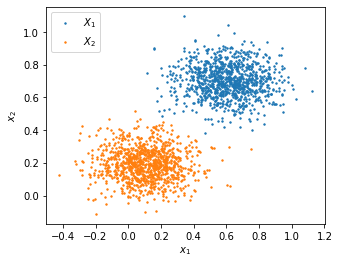

In [4]:
plt.figure(figsize=(5,4))
plt.scatter(X1[:,0],X1[:,1],label='$X_1$', rasterized=False, s=2)
plt.scatter(X2[:,0],X2[:,1],label='$X_2$', rasterized=False, s=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend();

Construct a tiny, linear network with two inputs. The network structure and loss function are the same as in the paper.

In [5]:
def get_model():
    model = keras.models.Sequential(layers=[
        keras.layers.Dense(2, input_shape=(2,), name='input_layer', dtype='float64')
    ])

    @tf.function
    def loss(y_pred, y_true):
        return tf.math.reduce_sum(tf.math.square(y_pred - y_true))

    model.compile(loss=loss)
    model.summary()
    
    return model

In [10]:
model = get_model()
optimizer = PHOpt(alpha=1.0, beta=0.0, gamma=1.0, resistive=1.0, ivp_period=2.0)

optimizer.train(model, X_train, Y_train, epochs=4, metrics=[keras.metrics.CategoricalAccuracy()])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
1500/1500 [==============================] - 14s 9ms/step - loss: 1.1991 - energy: 1.6128 - categorical_accuracy: 0.9983
Epoch 2/4
1500/1500 [==============================] - 15s 10ms/step - loss: 1.8362 - energy: 1.4889 - categorical_accuracy: 0.9991
Epoch 3/4
1500/1500 [==============================] - 15s 10ms/step - loss: 1.4177 - energy: 1.4919 - categorical_accuracy: 1.0000
Epoch 4/4
1500/1500 [==============================] - 16s 11ms/step - loss: 1.0189 - energy: 1.5094 - categorical_accuracy: 0.9996


Okay, the training's done.

From the output above, we see that the training for each epoch took between 14 and 16 seconds.

The training reports 99.96% categorical accuracy, i.e. that 99.96% of points within the _training_ dataset were categorized correctly.

Let's plot the points in the _testing_ dataset and find out whether they are classified correctly.

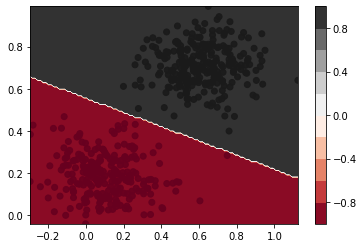

In [12]:
x_range = (X_test.min(0)[0], X_test.max(0)[0])
y_range = (X_test.min(0)[1], X_test.max(0)[1])

num_p = 100

u1 = np.linspace(*x_range, num_p)
u2 = np.linspace(*y_range, num_p)

U1, U2 = np.meshgrid(u1, u2)
Z = np.zeros((num_p, num_p))

for i in range(num_p):
    for j in range(num_p):
        u = tf.convert_to_tensor([[U1[i,j], U2[i,j]]])
        
        value = model(u)
        classification = -1 if value[0,0] - value[0,1] <= 0 else 1
        
        Z[i,j] = classification

plt.figure()
plt.contourf(U1, U2, Z, 10,cmap='RdGy')
plt.colorbar()
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test[:,0],cmap='RdGy',alpha = 0.9)
plt.xlim(x_range)
plt.ylim(y_range);

From the graphic above, we can conclude that all 500 points within the test dataset were categorized correctly. :)